# Confirm publised ages in Bouma+2024b
* https://ui.adsabs.harvard.edu/abs/2024ApJ...976..234B/abstract

In [2]:
# Inside this jupyter lab, do not use `pip install xxx`, instead use:
# import sys
# !{sys.executable} -m pip install xxx

In [2]:
#so just import from another directory
import sys
sys.path.insert(0, '../EAGLES/')

## Table 1 in Bouma+2024b

In [1]:
from astropy.io import ascii

url = "https://content.cld.iop.org/journals/0004-637X/976/2/234/revision1/apjad855ft1_mrt.txt"
tab = ascii.read(url)
tab[:3]

KIC,KOI,Kepler,Disp,Teff,e_Teff,r_Teff,Prot,e_Prot,r_Prot,EW,e_EW,tGyro,E_tGyro,e_tGyro,2Up-tGyro,2Lo-tGyro,tLi,E_tLi,e_tLi,Rp,r_Rp,Per,StarFlag,PlanetFlag,HiRes,Consist,f_tGyro,f_tLi
,,,,K,K,,d,d,,1e-13 m,1e-13 m,Myr,Myr,Myr,Myr,Myr,1e-13 m,1e-13 m,1e-13 m,Rgeo,,d,,,,,,
int64,str9,str14,str9,int64,int64,str19,str5,str5,str19,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,str19,float64,int64,int64,int64,str5,str6,str5
6184894,K05245.01,Kepler-1627 b,CONFIRMED,5357,95,2020AJ....159..280B,2.620,0.026,2021ApJS..255...17S,225,7,81,158,55,413,77,51,38,27,3.79,2022AJ....163..121B,7.2,2176,0,1,Yes,--,--
10736489,K07368.01,Kepler-1974 b,CONFIRMED,5068,76,2020AJ....159..280B,2.560,0.026,2021ApJS..255...17S,248,4,88,183,60,420,84,54,47,25,2.22,2022AJ....164..215B,6.84,2560,0,1,Yes,--,--
10717220,K06228.01,Kepler-1644 b,CONFIRMED,5521,109,2020AJ....159..280B,1.430,0.014,2021ApJS..255...17S,-2,13,77,144,53,409,74,--,--,--,1.88,10.26133/NEA4,21.09,2690,4,1,No,--,> 767


In [9]:
df = tab.to_pandas()
df.shape

(2461, 29)

In [10]:
# filter only confirmed planets (exclude Kepler candidates)

idx = df.Disp=='CONFIRMED' #& \
      # df.StarFlag==0 & \
      # df.PlanetFlag==0 &\

In [11]:
# filter
df = df[idx]
df.shape

(2107, 29)

In [12]:
df.columns

Index(['KIC', 'KOI', 'Kepler', 'Disp', 'Teff', 'e_Teff', 'r_Teff', 'Prot',
       'e_Prot', 'r_Prot', 'EW', 'e_EW', 'tGyro', 'E_tGyro', 'e_tGyro',
       '2Up-tGyro', '2Lo-tGyro', 'tLi', 'E_tLi', 'e_tLi', 'Rp', 'r_Rp', 'Per',
       'StarFlag', 'PlanetFlag', 'HiRes', 'Consist', 'f_tGyro', 'f_tLi'],
      dtype='object')

In [13]:
# convert to float
cols = ['Kepler','Prot','Teff','e_Prot','e_Teff', 'tGyro','E_tGyro','e_tGyro','EW','e_EW','tLi','E_tLi','e_tLi']
df[cols[1:]] = df[cols[1:]].astype(float)

## fit

In [36]:
import os

# need to change directory for EAGLES to work
os.chdir('../EAGLES/')

In [37]:
name = "Kepler-1627 b"
d = df.query("Kepler==@name").squeeze()
d

Kepler     Kepler-1627 b
Prot                2.62
Teff              5357.0
e_Prot             0.026
e_Teff              95.0
tGyro               81.0
E_tGyro            158.0
e_tGyro             55.0
EW                 225.0
e_EW                 7.0
tLi                 51.0
E_tLi               38.0
e_tLi               27.0
Name: 0, dtype: object

In [52]:
# for some reason, eagles wants inputs as array
LiEW = np.array([d.EW])
Teff = np.array([d.Teff])
eLiEW = d.e_EW
eTeff = d.e_Teff

In [125]:
from eagles import get_li_age

lagesmin=6.0
lagesmax=9.0
nAge=820
lAges, llike, lprob, p, chisq = get_li_age(LiEW, eLiEW, Teff, eTeff,
                                           lagesmin, lagesmax, 
                                           lApkmin=6.699, 
                                           nAge=nAge, z=1.0e-12, nTeff=21, prior=None)

In [126]:
chisq

-1

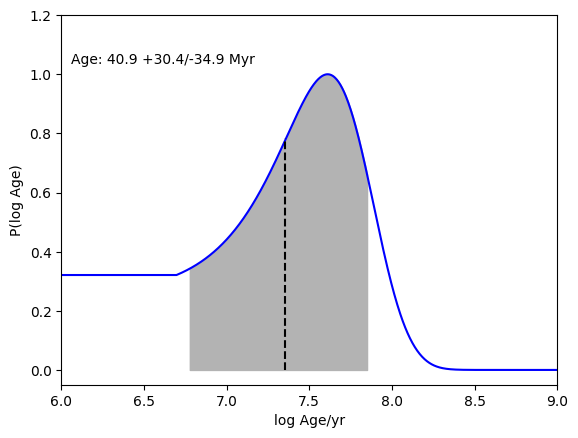

In [127]:
from eagles import make_plots

ID=None
filename=None

make_plots(lAges, lprob, p, chisq, lagesmin, lagesmax,
           ID, LiEW, eLiEW, Teff, filename, is_cluster=False, savefig=False)

In [128]:
#compare with published results
print(f"age of {name} = {d['tLi']} +{d['E_tLi']} -{d['e_tLi']}Myr")

age of Kepler-1627 b = 51.0 +38.0 -27.0Myr


In [129]:
# percentiles change depending on the age_grid

age_grid = lagesmin+(np.arange(nAge)+0.5)*(lagesmax-lagesmin)/float(nAge)
age_grid = (10**age_grid)/1e6
min(age_grid), max(age_grid)

(np.float64(1.0042209290348338), np.float64(995.7968123220747))

In [130]:
from gyrointerp import get_summary_statistics

# calculate dictionary of summary statistics
result = get_summary_statistics(age_grid, lprob)
print(f"Age = {result['median']} +{result['+1sigma']} -{result['-1sigma']} Myr.")

Age = 687.4 +213.13 -282.01 Myr.


## plot data

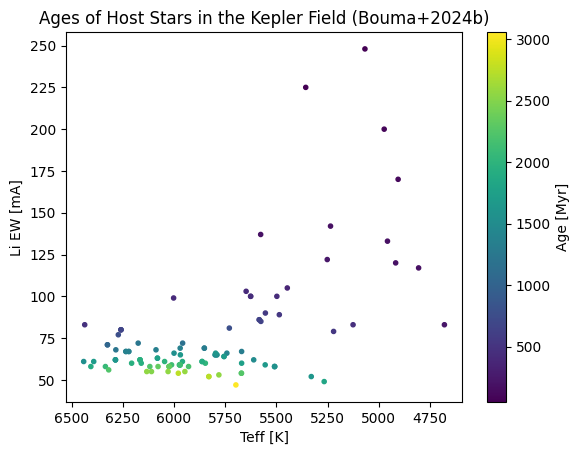

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
s = ax.scatter(df.Teff, df.EW, marker='.', c=df.tLi)
fig.colorbar(s, label='Age [Myr]')
ax.xaxis.set_inverted(True)
ax.update({
    'xlabel': 'Teff [K]',
    'ylabel': 'Li EW [mA]',
    'title': 'Ages of Host Stars in the Kepler Field (Bouma+2024b)'
    });

## plot also models from eagles

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# import the EWLi prediction model from the main EAGLES code
from eagles import AT2EWm
from eagles import eAT2EWm
from matplotlib.colors import ListedColormap

# Modify the list below for the isochrones you want to produce (units are Myr)
ages = [100, 500, 1000]
Nages = len(ages)
tmin, tmax = df.tLi.min(), df.tLi.max()
colors = ListedColormap(plt.cm.viridis(np.linspace(tmin/tmax, 1, Nages))).colors

# e.g. for fewer isochrones
#ages = [10, 100, 1000]

# Modify this flag to true if you want the plot to include the dispersion
# look smessy if there are many closely spaced isochrones
plot_dispersion = True

# The step in logarithmic temperature
tstep = 0.002

# parameters for the plot

fig, ax = plt.subplots()
plt.xlabel('Teff (K)')
plt.ylabel('LiEW (mA)')
ax.set_xlim(6500, 3000)

# set up a an equally spaced set of log temperatures between 3000 and 6500 K
lteff = np.arange(3.4772, 3.8130, tstep)

# loop over the ages
for c,t in zip(colors,ages):

    lAge = np.log10(t)+6  # log age in years
    ewm = AT2EWm(lteff, lAge)
    eewm = eAT2EWm(lteff, lAge)

    # save the results as a simple .txt file    
    # name = 'iso_'+str(t)+'.txt'
    # np.savetxt(name, np.column_stack((10**lteff, ewm, eewm)), fmt='%.1f %.1f %.1f', delimiter=' ', header = "Teff(K) EWLim(mA) eEWLi(mA)")
 
    ax.plot(10**lteff, ewm, label=f'{t} Myr', c=c)

    # if the plot_dispersion flag then shade the dispersion region
    # looks quite messy if there are lots of isochrones because of the overlap
    if plot_dispersion :
        plt.fill_between(10**lteff, ewm-eewm, ewm+eewm, alpha=0.3,color=c)

# For the default list of ages and plot_dispersion = False, this is Fig.2 from the paper    

if len(ages) <6 :
    plt.legend()
else :
    ax.text(0.01,0.95, str(ages)+" Myr", transform=ax.transAxes)

# kepler data
s = ax.scatter(df.Teff, df.EW, marker='.', c=df.tLi)
# fig.colorbar(s, label='Age [Myr]')
ax.xaxis.set_inverted(True)
ax.update({
    'xlabel': 'Teff [K]',
    'ylabel': 'Lithium EW [mA]',
    'title': 'Li Ages of Host Stars in the Kepler Field (Bouma+2024b)'
    });
ax.legend(title='Age [Myr]', loc='upper left')

## top candidates (age from gyro & lithium < 1 Gyr)

In [31]:
# get consistent tGyro and tLi
idx = df['Consist']=='Yes'
# remove columns with NaN
df = df.loc[idx,cols].dropna()
df.shape

(60, 13)

In [32]:
#filter main results: host stars with age<1Gyr (E_age = age upper limit)
idx = df[['E_tGyro','E_tLi']]<1000
idx.head()

,E_tGyro,E_tLi
0,True,True
1,True,True
3,True,True
5,True,True
8,True,True


In [33]:
#make sure idx is True when both columns are True
idx.all(axis=1)

0       True
1       True
3       True
5       True
8       True
9       True
11      True
12      True
13      True
15      True
17      True
19      True
23      True
24      True
28      True
31      True
32      True
33      True
44      True
53     False
54     False
58     False
59     False
60     False
79     False
80     False
105    False
129    False
143    False
160    False
174    False
190    False
216    False
223    False
225    False
226    False
227    False
251    False
263    False
294    False
295    False
301    False
302    False
303    False
345    False
346    False
347    False
352    False
353    False
381    False
385    False
418    False
419    False
420    False
421    False
469    False
493    False
545    False
578    False
639    False
dtype: bool

In [34]:
df[idx.all(axis=1)]

,Kepler,Prot,Teff,e_Prot,e_Teff,tGyro,E_tGyro,e_tGyro,EW,e_EW,tLi,E_tLi,e_tLi
0,Kepler-1627 b,2.62,5357.0,0.026,95.0,81.0,158.0,55.0,225.0,7.0,51.0,38.0,27.0
1,Kepler-1974 b,2.56,5068.0,0.026,76.0,88.0,183.0,60.0,248.0,4.0,54.0,47.0,25.0
3,Kepler-1643 b,5.05,4918.0,0.050,83.0,79.0,182.0,54.0,120.0,6.0,191.0,92.0,76.0
5,Kepler-1529 b,6.43,4974.0,0.060,99.0,109.0,117.0,71.0,200.0,6.0,90.0,53.0,39.0
8,Kepler-1930 b,7.10,4906.0,0.070,89.0,174.0,106.0,65.0,170.0,4.0,115.0,55.0,49.0
9,Kepler-1928 b,4.64,5577.0,0.046,86.0,148.0,102.0,87.0,137.0,4.0,189.0,150.0,94.0
11,Kepler-1313 b,6.13,5236.0,0.060,85.0,197.0,112.0,91.0,142.0,3.0,174.0,96.0,72.0
12,Kepler-1565 b,7.40,4958.0,0.070,96.0,230.0,111.0,85.0,133.0,7.0,174.0,81.0,72.0
13,Kepler-1521 b,7.82,4806.0,0.080,80.0,207.0,98.0,68.0,117.0,5.0,176.0,79.0,69.0
15,Kepler-63 b,5.49,5486.0,0.050,82.0,223.0,98.0,92.0,89.0,4.0,542.0,475.0,256.0


## confirm published ages using gyro-interp

In [ ]:
name = "Kepler-1627 b"
d = df.query("Kepler==@name").squeeze()
d

Kepler     Kepler-1627 b
Prot                2.62
Teff              5357.0
e_Prot             0.026
e_Teff              95.0
tGyro               81.0
E_tGyro            158.0
e_tGyro             55.0
tLi                 51.0
E_tLi               38.0
e_tLi               27.0
Name: 0, dtype: object

In [ ]:
Prot = d.Prot
Teff = d.Teff
Prot_err = d.e_Prot
Teff_err = d.e_Teff

In [ ]:
import numpy as np
from gyrointerp import gyro_age_posterior
from gyrointerp import get_summary_statistics

# uniformly spaced grid between 0 and 2600 Myr
age_grid = np.linspace(0, 2600, 500)

# calculate the age posterior - takes ~30 seconds
age_posterior = gyro_age_posterior(Prot, 
                                   Teff, 
                                   Prot_err=Prot_err, 
                                   Teff_err=Teff_err, 
                                   age_grid=age_grid,
                                   #bounds_error='4gyrextrap', #for older star
)

# calculate dictionary of summary statistics
result = get_summary_statistics(age_grid, age_posterior)
print(f"Age = {result['median']} +{result['+1sigma']} -{result['-1sigma']} Myr.")

[W 250327 15:47:40 gyro_posterior:361] WARNING: imposing period uncertainty floor of 0.03d The purpose of this floor is to prevent N_grid from growing too large.  This is justified because the gyro model has no information content on this scale.


Age = 80.79 +158.8 -55.19 Myr.


In [ ]:
#compare with published results
print(f"age of {name} = {d['tGyro']} +{d['E_tGyro']} -{d['e_tGyro']}Myr")

age of Kepler-1627 b = 81.0 +158.0 -55.0Myr


## plot age distribution

In [ ]:
import matplotlib.pyplot as plt

def plot_age_posterior(name, Prot, Teff, age_posterior, age_stat, age_grid):
    fig, ax = plt.subplots()
    
    # add vertical lines
    x1 = int(age_stat['-1sigma'])
    med = int(age_stat['median'])
    x2 = int(age_stat['+1sigma'])
    lbl = f"Age = {med} + {x2} - {x1} Myr"
    
    ax.plot(age_grid, 1e3*age_posterior, c='k', lw=1, marker='.',label=lbl)
    ax.update({
        'xlabel': 'Age [Myr]',
        'ylabel': 'Probability ($10^{-3}\,$Myr$^{-1}$)',
        'title': f'{name} (Prot = {Prot}d, Teff = {Teff}K)',
        'xlim': [0,1000]
    })
    
    for i,v in zip(['-1sigma','median','+1sigma'],[med-x1,med,med+x2]):
        ls = '-' if i=='median' else '--'
        ax.axvline(v, ls=ls)
    ax.legend()
    return fig

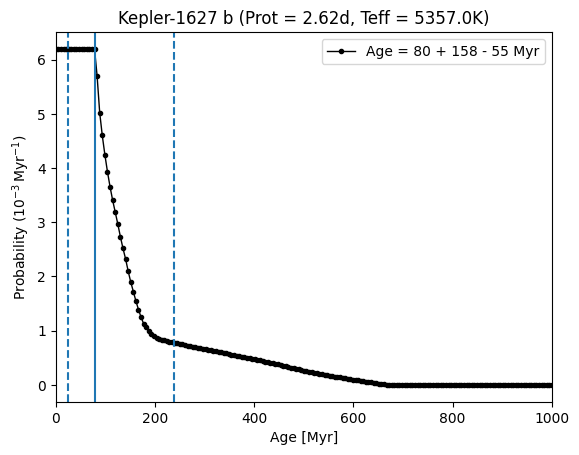

In [21]:
fig = plot_age_posterior(name, Prot, Teff, age_posterior, result, age_grid)

fp = name.replace(' ','')+'_age_gyro.png'
fig.savefig(fp, bbox_inches='tight')

## older age

In [22]:
# units: days
name = 'Kepler-447 b'
d = df.query("Kepler==@name").squeeze()
Prot = d.Prot
Teff = d.Teff
Prot_err = d.e_Prot
Teff_err = d.e_Teff

# calculate the age posterior at each age in `age_grid`
age_posterior = gyro_age_posterior(
    Prot, Teff,
    Prot_err=Prot_err, Teff_err=Teff_err,
    age_grid=age_grid,
    # bounds_error='4gyrextrap', #for older star
)

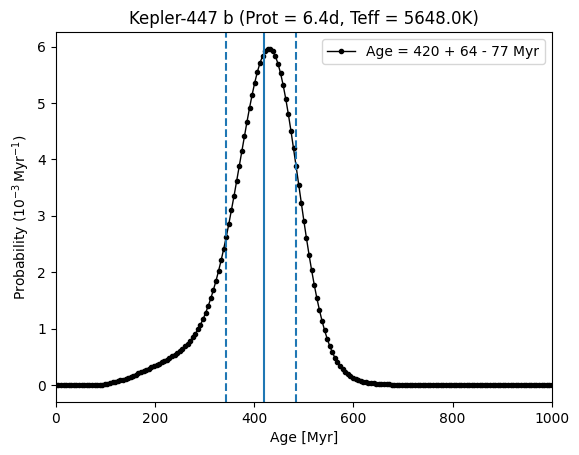

In [23]:
result = get_summary_statistics(age_grid, age_posterior)
fig = plot_age_posterior(name, Prot, Teff, age_posterior, result, age_grid)

In [24]:
#compare with published results
print(f"age of {name} = {d['tGyro']} +{d['E_tGyro']} -{d['e_tGyro']}Myr")

age of Kepler-447 b = 420.0 +64.0 -78.0Myr


ages in Bouma+2024b is confirmed.

## Summary

* 100<age<1000 Myr posterior looks Gaussian so the age limits are more reliable.